In [12]:
import numpy as np
from scipy.linalg import expm
from random import sample, shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
Gamma_to_sink=5.
nsig = 5

#System evolution
def evolve(r0, H, t):
    N_in=H.shape[0]
    
    I=np.eye(N_in, dtype="complex64")
    sm=np.zeros([N_in,N_in], dtype="complex64")
    sm[0,2]=1
    sp=np.zeros([N_in,N_in], dtype="complex64")
    sp[2, 0]=1
    
    L_uni=np.kron(I, H)-np.kron(H.transpose().conjugate(), I)
    L_sink=Gamma_to_sink*(2*np.kron(sp.transpose(), sm)-np.kron(I, sp@sm)-np.kron((sp@sm).transpose().conjugate(), I))
    return (expm((1j*L_uni+L_sink)*t)@r0).real[0]


#Chain class
class QNetwork:
    def __init__(self, J0=1., T=1., N_max=11):
        self.J=J0
        self.T=T
        self.DE=1.
        self.N_max=N_max
        self.sigma = 0.5/(nsig*(N_max-1))
        self.limit_disorder = 0.5/(N_max-1) - 1e-8
        
        self.nodes_coordinates=np.zeros(self.N_max)
        self.nodes_coordinates[0]=1.
        self.nodes_coordinates[-1]=1.
        self.nodes_positions=[np.array([-1.]), np.array([0.]), np.array([1.])]
        self.nodes_info=np.zeros(self.N_max)
   
        self.H=np.zeros([3,3], dtype="complex64")
        self.H[1,1]=self.DE
        self.H[2,2]=self.DE
        self.H[1,2]=self.J
        self.H[2,1]=self.J
        self.rho0=np.zeros([3,3])
        self.rho0[1,1]=1
        self.rho0=self.rho0.reshape(9)
    
    #Interactions
    def H_ij(self, x_i, x_j):
        return self.J/((np.linalg.norm(x_j-x_i))**3)
    
    #Add new node to the chain and update Hamiltonian and state
    def add_node(self, nx):
        self.nodes_coordinates[nx]=1.
        x=float(nx)/(self.N_max-1) + max(-self.limit_disorder, min(np.random.normal(scale=self.sigma), self.limit_disorder))  #qui puoi aggiungere disordine
        
        id_last=self.H.shape[0]
        H_new = self.H.copy()
        H_new=np.vstack((np.hstack((H_new, np.zeros([id_last,1], complex))), np.zeros([1,id_last+1], complex)))
        for i in range(1, id_last):
            H_new[id_last,i]=self.H_ij(x, self.nodes_positions[i])
            H_new[i, id_last]=H_new[id_last,i]
        H_new[id_last, id_last]=self.DE
        
        rho0=np.zeros([id_last+1, id_last+1])
        rho0[1,1]=1
        rho0=rho0.reshape((id_last+1)**2)
        
        self.rho0=rho0
        self.nodes_positions+=[np.array(x)]
        self.H=H_new
     
    
    #FOR REINFORCEMENT LEARNING 
    #Reset chain to the original configuration
    def reset(self):
        self.nodes_coordinates=np.zeros(self.N_max)
        self.nodes_coordinates[0]=1.
        self.nodes_coordinates[-1]=1.
        self.nodes_positions=[np.array([-1.]), np.array([0.]), np.array([1.])]
        self.nodes_info=np.zeros(self.N_max)
   
        self.H=np.zeros([3,3], dtype="complex64")
        self.H[1,1]=self.DE
        self.H[2,2]=self.DE
        self.H[1,2]=self.J
        self.H[2,1]=self.J
        self.rho0=np.zeros([3,3])
        self.rho0[1,1]=1
        self.rho0=self.rho0.reshape(9)
        return self.nodes_coordinates
    
    #MDP step
    def step(self, action):
        terminated=False
        if self.nodes_coordinates[action]<1:
            r0 = evolve(self.rho0, self.H, self.T)
            self.add_node(action)
            r1 = evolve(self.rho0, self.H, self.T)
            reward = r1 - r0
            self.nodes_info[action] = (r1+1.)/2.
            if r1>0.99: terminated = True
        else:
            reward = 0.
            #terminated = True
        
        return self.nodes_info, reward, terminated

In [14]:
eps=1e-10

#Physical parameters
N=21
J0=0.05
T=5.

#environment
num_obs = N
num_acts = N
max_steps_per_episode=11

#learning
gamma=0.99
lmbda = 0.95
num_agents = 100
num_epochs = 4
batchsize = 128
#cS = 0.001

clip_ratio = 0.2
kinit = tf.keras.initializers.HeUniform()
loss_function = keras.losses.Huber() #MeanSquaredError() #

lr_actor = 8e-5
optimizer_actor = keras.optimizers.Adam(learning_rate=lr_actor)

lr_critic= 1e-4
optimizer_critic = keras.optimizers.Adam(learning_rate=lr_critic)


#Actor
inputs_act = layers.Input(shape=(num_obs,))
hid_act = layers.Dense(128, activation="relu", kernel_initializer=kinit)(inputs_act)
hid_act = layers.Dense(128, activation="relu", kernel_initializer=kinit)(hid_act)
hid_act = layers.Dense(128, activation="relu", kernel_initializer=kinit)(hid_act)
output_act = layers.Dense(num_acts, activation="softmax")(hid_act)
actor = keras.Model(inputs=inputs_act, outputs=output_act)

#Critic
inputs_crit = layers.Input(shape=(num_obs,))
hid_crit = layers.Dense(128, activation="relu", kernel_initializer=kinit)(inputs_crit)
hid_crit = layers.Dense(128, activation="relu", kernel_initializer=kinit)(hid_crit)
hid_crit = layers.Dense(128, activation="relu", kernel_initializer=kinit)(hid_crit)
hid_crit = layers.Dense(128, activation="relu", kernel_initializer=kinit)(hid_crit)
output_crit = layers.Dense(1, activation="linear")(hid_crit)
critic = keras.Model(inputs=inputs_crit, outputs=output_crit)

#Initialize
opt=[]
current_max=-100

env = QNetwork(J0, T, N)

In [15]:
def preprocess(states, actions, rewards, done, values): 
    g = 0
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * done[i] - values[i]
        g = delta + gamma * lmbda * done[i] * g
        returns.append(g + values[i])

    returns.reverse()
    adv = np.array(returns, dtype=np.float32) - values[:-1]
    return returns, adv.tolist()

def learn_epoch(states, actions, advs, old_probs, returns):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            probs = actor(states)
            values = critic(states)
            L_clip = -sum([min(advs[batch]*probs[batch][actions[batch]]/old_probs[batch][actions[batch]], tf.clip_by_value(probs[batch][actions[batch]]/old_probs[batch][actions[batch]], 1.-clip_ratio, 1.+clip_ratio)*advs[batch]) for batch in range(batchsize)])/batchsize
            L_crit = loss_function(values, returns.astype("float32"))
            #L_entropy = -sum([-tf.tensordot(probs[batch], tf.math.log(probs[batch]+eps), axes=1) for batch in range(batchsize)])/batchsize
         
                
            grads1 = tape1.gradient(L_clip, actor.trainable_variables) #+cS*L_entropy
            grads2 = tape2.gradient(L_crit, critic.trainable_variables)
        
            optimizer_actor.apply_gradients(zip(grads1, actor.trainable_variables))
            optimizer_critic.apply_gradients(zip(grads2, critic.trainable_variables))
    
    return L_clip.numpy(), L_crit.numpy(), 0#cS*L_entropy.numpy()

In [16]:
actions_history = []
states_history = []
advs_history = []
returns_history = []
probs_history = []

test_performance = []

num_episodes = 6000
episode_count = 0

while True:
    opt_rew=-100
    performance_episode = 0
    for agent in range(num_agents):
        actions_agent = []
        states_agent = []
        values_agent = []
        done_agent = []
        rewards_agent = []
        probs_agent = []
        
        state=env.reset()
        for timestep in range(1, max_steps_per_episode):
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = actor(state_tensor, training=False)
            critic_values = critic(state_tensor, training=False)
            action = np.random.choice(num_acts, p=np.squeeze(action_probs))
            
            state_next, reward, done = env.step(action)
            state_next = np.array(state_next, dtype=np.float32)
            
            probs_agent.append(np.squeeze(action_probs))
            actions_agent.append(action)
            states_agent.append(state)
            values_agent.append(critic_values.numpy()[0][0])
            done_agent.append(1-done)
            rewards_agent.append(reward)
            state = state_next
            
            performance_episode+=reward
            if reward>opt_rew: opt_rew=reward
            
            if done:
                break
                
        final_pops = evolve(env.rho0, env.H, env.T)
        if final_pops > current_max:
            current_max = final_pops
            opt = env.nodes_coordinates
                
        values_agent.append(0.)
            
        returns_agent, advs_agent = preprocess(states_agent, actions_agent, rewards_agent, done_agent, values_agent)
        
        actions_history += actions_agent
        states_history += states_agent
        returns_history += returns_agent
        advs_history += advs_agent
        probs_history += probs_agent
        
    #advs_history = ((np.array(advs_history) - np.array(advs_history).mean())/np.array(advs_history).std()).tolist()
    test_performance += [performance_episode/(num_agents)]
    
    lossA = 0
    lossC = 0
    lossS = 0
    for epoch in range(num_epochs):
        indices = np.random.choice(range(len(returns_history)), size=batchsize)
        states_sample = np.array([states_history[i] for i in indices])
        actions_sample = np.array([actions_history[i] for i in indices])
        probs_sample = np.array([probs_history[i] for i in indices])
        returns_sample = np.array([returns_history[i] for i in indices])
        advs_sample = np.array([advs_history[i] for i in indices])
        lossA_epoch, lossC_epoch, lossS_epoch = learn_epoch(states_sample, actions_sample, advs_sample, probs_sample, returns_sample)
        lossA += lossA_epoch/num_epochs
        lossC += lossC_epoch/num_epochs
        lossS += lossS_epoch/num_epochs
    
    max_prob = probs_history[0].max()
    
    actions_history.clear()
    states_history.clear()
    returns_history.clear()
    advs_history.clear()
    probs_history.clear()
    
    state=env.reset()
    for timestep in range(1, max_steps_per_episode):
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = actor(state_tensor, training=False)
        critic_values = critic(state_tensor, training=False)
        action = np.argmax(np.squeeze(action_probs))
        state_next, reward, done = env.step(action)
        state_next = np.array(state_next, dtype=np.float32)
        state=state_next
        if done: break    
    final_pops = evolve(env.rho0, env.H, env.T)
    
    print(episode_count, current_max, final_pops, opt_rew, max_prob, lossC, test_performance[-1])
    
    episode_count+= 1   
    if episode_count>num_episodes:
        break

0 0.9976962191293242 0.0012705508935479848 0.9305295179341595 0.07965554 0.20212118700146675 0.016447816307922403
1 0.9976962191293242 0.001963782799686004 0.9411575183238473 0.079125725 0.14818738400936127 0.012692951051421698
2 0.9993202468645196 0.0014470626475734248 0.9228383935039421 0.07832525 0.08406613022089005 0.028040699863030566
3 0.9993202468645196 0.00130690913843054 0.9753617008134942 0.07778923 0.04930758196860552 0.01659817453283847
4 0.9993202468645196 0.001777800215296253 0.8672176967928681 0.07743493 0.0410603191703558 0.012632624812341137
5 0.9993202468645196 0.0010684013664272695 0.7570992583652483 0.077397175 0.03445721743628383 0.01179077340703313
6 0.9993202468645196 0.001639304351806226 0.8596267518700343 0.07729783 0.038010813761502504 0.012275400894589544
7 0.9993202468645196 0.001586294857581375 0.9178371042931915 0.07742333 0.03768525458872318 0.010200455610996886
8 0.9993202468645196 0.0011146854624994155 0.9107528346320829 0.077350326 0.03313623461872339 

72 0.9997206452206691 0.0021564692040956642 0.8701686003953785 0.089036524 0.0164681957103312 0.029569562421826432
73 0.9997206452206691 0.0005168087240028215 0.8936276829341645 0.089278966 0.012476332951337099 0.02533889104048851
74 0.9997206452206691 0.0002080390774805379 0.9804787391674735 0.09009927 0.019035774748772383 0.04738271555575848
75 0.9997206452206691 0.04370700762517103 0.9816729577253868 0.09075565 0.010695725330151618 0.02322412104255445
76 0.9997206452206691 0.0050894211429020515 0.9783971683682946 0.09097842 0.013740604044869542 0.04437610573522988
77 0.9997206452206691 0.00205233546829006 0.9002466034175768 0.090961955 0.014354511629790068 0.02209041946143286
78 0.9997206452206691 0.009434258396921205 0.9053701326448983 0.09117091 0.02098833490163088 0.030491362288241425
79 0.9997206452206691 0.018361661061903123 0.9463562568884336 0.09151967 0.008614956168457866 0.02269883117817568
80 0.9997206452206691 0.018215566921289474 0.8332573612064826 0.092012286 0.01626183

144 0.9998393823362145 0.015104942106605184 0.9505895933422136 0.10901223 0.017137440852820873 0.02932796695864153
145 0.9998393823362145 0.027442448838845324 0.7082560846250923 0.10939781 0.01260553824249655 0.043517735684397776
146 0.9998393823362145 0.03008530996738349 0.8633673577989729 0.11031899 0.008923284243792295 0.015392278756868548
147 0.9998393823362145 0.015655489842654476 0.7925559210789749 0.11098896 0.009844700223766267 0.009124633822519298
148 0.9998393823362145 0.031599997141033655 0.9133450582459273 0.11142111 0.014780788565985858 0.03621687381727088
149 0.9998393823362145 0.020581021014599736 0.8323410906362929 0.11163763 0.012396177044138312 0.027607812636199207
150 0.9998393823362145 0.02165950771976484 0.95410209543739 0.111717455 0.01583373174071312 0.049504833068786704
151 0.9998393823362145 0.017262078327386268 0.8252148302603884 0.11157677 0.01445734640583396 0.018605988609151393
152 0.9998393823362145 0.02491474490274489 0.8459539925429883 0.11180962 0.01312

216 0.9998393823362145 0.06747730785988698 0.8995393599795863 0.12830175 0.017476640408858657 0.04439360997679926
217 0.9998393823362145 0.036618486664288526 0.9233709387261128 0.1282167 0.018187097273766994 0.048076694090915105
218 0.9998393823362145 0.027814939685360095 0.8230465412964447 0.12846793 0.010605900548398495 0.035378947228411
219 0.9998393823362145 0.03390663224580107 0.9481623708154678 0.12820847 0.014592497143894434 0.05382345652021521
220 0.9998393823362145 0.009155095825653721 0.8458655969374107 0.12749574 0.01664893259294331 0.05396884712926091
221 0.9998393823362145 0.025043717619903788 0.9543810973818374 0.12690742 0.013747266144491732 0.0410324226875165
222 0.9998393823362145 0.033029515182012824 0.913423896434084 0.12680367 0.012802541255950928 0.02396757790480393
223 0.9998393823362145 0.03499480470683754 0.9098162636944733 0.12671185 0.004708769964054227 0.0030411874382012855
224 0.9998393823362145 0.021963284157708818 0.9524439147656627 0.12677708 0.0196921154

288 0.9999235714133401 0.03125883764576939 0.942031025192594 0.13912474 0.023165293503552675 0.09535514959208663
289 0.9999235714133401 0.01734441234160043 0.8029471950680367 0.13993305 0.012247883481904864 0.07563486881480817
290 0.9999235714133401 0.008818291538842305 0.9255799952262429 0.14061356 0.012931674951687455 0.04214178853069675
291 0.9999235714133401 0.028658507068078758 0.912814224223121 0.1412808 0.026831822004169226 0.11778444128203885
292 0.9999235714133401 0.007256972420711223 0.8916421571906026 0.14067397 0.02086086431518197 0.04476635241717774
293 0.9999235714133401 0.01587669514157623 0.9264290231091308 0.14048919 0.016223831102252007 0.0427546848608006
294 0.9999235714133401 0.01132122449155301 0.9420824077555985 0.14126723 0.013235437450930476 0.045698405600824596
295 0.9999235714133401 0.021576785757058056 0.8331306804539356 0.14259964 0.013570912182331085 0.03872969746899253
296 0.9999235714133401 0.02419755272965016 0.9391684246238083 0.14353265 0.0220629209652

360 0.9999235714133401 0.028334509070918435 0.9535095812083688 0.19119179 0.013977458467707038 0.07204830515420635
361 0.9999235714133401 0.03326211984073188 0.991777942608719 0.18905114 0.02335831127129495 0.12648259301970252
362 0.9999235714133401 0.03657095782042812 0.9891238297361719 0.18778847 0.028161107562482357 0.11363909030212455
363 0.9999235714133401 0.0335826201512923 0.8994101874426715 0.18792963 0.017215689178556204 0.08097744967614147
364 0.9999235714133401 0.0336734248422863 0.9546491378752964 0.1880668 0.02953972201794386 0.1614801291682534
365 0.9999235714133401 0.035772361030607214 0.9289684524293121 0.18706453 0.016366112511605024 0.07578332800511299
366 0.9999235714133401 0.0343983164764182 0.9555195217813149 0.18799962 0.02204276528209448 0.10327053161507317
367 0.9999235714133401 0.03461825245506933 0.9356069624285321 0.18900616 0.01313774916343391 0.055669586590511536
368 0.9999235714133401 0.03490800481414659 0.9394009484620883 0.18942575 0.020836343057453632 0

433 0.9999328128502483 0.9985153031460517 0.9800266016204029 0.23392704 0.06975608598440886 0.56941960330963
434 0.9999328128502483 0.9966363750066594 0.9539058624018035 0.24090146 0.06838296726346016 0.46159064361559154
435 0.9999328128502483 0.9858909930301525 0.9664006322251159 0.2512663 0.06264868564903736 0.512537647852241
436 0.9999328128502483 0.9986663465092321 0.9561619202298915 0.26452842 0.06713768281042576 0.5211416978355269
437 0.9999328128502483 0.9988705269825388 0.9806010293798385 0.28313777 0.06631278432905674 0.5859503986294553
438 0.9999328128502483 0.983672398533546 0.9605192514683242 0.29232708 0.06804191507399082 0.5144171696715287
439 0.9999475822931702 0.9721073178351096 0.9606016075302828 0.2887839 0.06785368546843529 0.6156729323551132
440 0.9999475822931702 0.997141888504393 0.9500691516904465 0.27828386 0.06921750493347645 0.5457316319403691
441 0.9999475822931702 0.998647941661292 0.957949859591224 0.26556784 0.07247963733971119 0.6473002568133159
442 0.999

508 0.9999578216697306 0.9972090128726557 0.9559944916793937 0.32251427 0.09520908445119858 0.8853242641111291
509 0.9999578216697306 0.9989529949096687 0.9562124639436147 0.3212446 0.09368565119802952 0.8775153947081412
510 0.9999578216697306 0.9605937132696986 0.9590553257461497 0.33149746 0.08750348351895809 0.9220270780272262
511 0.9999578216697306 0.9991227333072429 0.9845261345552692 0.32834724 0.08982748538255692 0.8426234705639293
512 0.9999578216697306 0.9610590024828045 0.9583544503668308 0.33496043 0.08588224276900291 0.8773576273434907
513 0.9999578216697306 0.9971852976772354 0.9623206304276531 0.33137518 0.08303758315742016 0.9102207229558226
514 0.9999578216697306 0.9988177438012352 0.9603095764820756 0.32294473 0.08638240955770016 0.9071395587274025
515 0.9999578216697306 0.9993021962154583 0.9628606730351479 0.3294904 0.08565882779657841 0.8665720031197778
516 0.9999578216697306 0.9849588762856085 0.9577944114722244 0.31823203 0.0907580591738224 0.9160522075614982
517 

583 0.9999578216697306 0.9942847924921128 0.9589241594696799 0.35271186 0.08296348340809345 0.9377003636257613
584 0.9999578216697306 0.9407224820234501 0.9572975694806716 0.34436494 0.08754893392324448 0.9439737779945517
585 0.9999578216697306 0.9989641083811065 0.9610491836687313 0.34846747 0.08890427835285664 0.9674456249797702
586 0.9999578216697306 0.9988807290939173 0.9608088474710842 0.36586258 0.08823688887059689 0.9417266892165606
587 0.9999578216697306 0.9990994723689399 0.9583963704576296 0.37866724 0.08656841889023781 0.906587170796776
588 0.9999578216697306 0.9992856217992604 0.9592789005445496 0.39722705 0.08699505403637886 0.9205476163766885
589 0.9999578216697306 0.998075913024843 0.9632537332771713 0.39690873 0.08239223249256611 0.9534940231421024
590 0.9999578216697306 0.9667993091585678 0.9617509324606311 0.38203856 0.08475839532911777 0.953623562521474
591 0.9999578216697306 0.9957732053941578 0.9584769200030976 0.39086223 0.08228138834238052 0.9530334180401993
592 

658 0.9999578216697306 0.9983906091435504 0.9604893028895092 0.3847767 0.08834332786500454 0.9528118356585459
659 0.9999578216697306 0.9995077362640507 0.9579746748650266 0.37863055 0.09151159599423409 0.9414480928851031
660 0.9999578216697306 0.9582775928253984 0.9617235213048312 0.36960477 0.08977171778678894 0.9397088451644923
661 0.9999578216697306 0.983084911237304 0.9610950669418288 0.36832407 0.08213802799582481 0.932217211513254
662 0.9999578216697306 0.9903854375523402 0.9606350940039343 0.37522766 0.08314100839197636 0.9638685626727418
663 0.9999578216697306 0.9838870159812482 0.9626359871360026 0.3862209 0.08770338632166386 0.9328243342321778
664 0.9999578216697306 0.939024153248598 0.9615850234839449 0.4076095 0.09593320824205875 0.9356979322829097
665 0.9999578216697306 0.9827414885540889 0.9598252363634692 0.41704088 0.0886881835758686 0.9671755565955144
666 0.9999578216697306 0.9900761112254107 0.9610421783443719 0.40423322 0.08644728548824787 0.9527994856139851
667 0.99

733 0.9999578216697306 0.9961539686222458 0.9633133054736466 0.36952597 0.0882277563214302 0.9359321294431665
734 0.9999578216697306 0.9992262247430084 0.9561240650576781 0.380283 0.08632304146885872 0.9289801004818837
735 0.9999578216697306 0.9991368769304296 0.9622122774916501 0.37933645 0.08722360618412495 0.962044932484345
736 0.9999578216697306 0.9992098834753662 0.9600101264929104 0.3740923 0.08279784210026264 0.9637414774925095
737 0.999973579303292 0.9956928266529181 0.959739294324918 0.36847892 0.09164039604365826 0.9420137475136502
738 0.999973579303292 0.9944016333372709 0.9581908736157158 0.37265462 0.0912319291383028 0.9397439939058668
739 0.999973579303292 0.989498176303691 0.9576630318992037 0.37912557 0.07924402877688408 0.9592098617471083
740 0.999973579303292 0.8842849440523276 0.9576675783931552 0.38599065 0.08143231831490993 0.9557546237948574
741 0.999973579303292 0.9996931276859022 0.9587548334531291 0.37420613 0.09023208916187286 0.920241039779547
742 0.999973579

809 0.999973579303292 0.998592068134028 0.9598819364816463 0.40555274 0.08484455943107605 0.9740939956263461
810 0.999973579303292 0.9974526864409838 0.960097651364798 0.4102644 0.08660724945366383 0.9513298124769979
811 0.999973579303292 0.9984454562507723 0.9594662950621953 0.41034806 0.07672942616045475 0.9641276039657339
812 0.999973579303292 0.9968648215723154 0.9588911473134085 0.4007906 0.08235004544258118 0.9534953471702627


KeyboardInterrupt: 

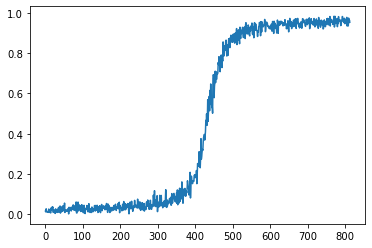

In [17]:
plt.plot(test_performance)

In [42]:
Ntests = 5000
final_pops = 0.
avg_n = []
for n in range(Ntests):
    state=env.reset()
    for timestep in range(1, max_steps_per_episode):
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = actor(state_tensor, training=False)
        critic_values = critic(state_tensor, training=False)
        action = np.argmax(np.squeeze(action_probs))
        state_next, reward, done = env.step(action)
        state_next = np.array(state_next, dtype=np.float32)
        state=state_next
        if done: break    
    final_pops += evolve(env.rho0, env.H, env.T)
    avg_n+=[sum(env.nodes_coordinates)]
print(final_pops/float(Ntests))
avg_n = np.array(avg_n)
print(avg_n.mean())

0.9868962628983842
5.0


In [21]:
np.savetxt("PPOchain_grid21_disordered5sigma_J_0_05_adaptive_learning.csv", np.array(test_performance), delimiter=",")

In [32]:
actor.save("PPOchain_adaptive_actor")
critic.save("PPOchain_adaptive_critic")

INFO:tensorflow:Assets written to: PPOchain_adaptive_actor\assets
INFO:tensorflow:Assets written to: PPOchain_adaptive_critic\assets
